# พยากรณ์ดัชนีราคาผู้บริโภคโดยแบบจำลอง SARIMA

In [151]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy.stats import boxcox_normmax

# 1. จัดเตรียมข้อมูล

In [375]:
data = pd.read_csv('/Users/1hundredeyes/consumer_price_index.csv')

* ตรวจสอบค่า Null ในชุดข้อมูล

In [240]:
data.isnull().sum()

cpi    0
dtype: int64

* สร้าง Index ให้เป็น datetime เพื่อให้สะดวกต่อการวิเคราะห์ตัวแบบ SARIMA

In [377]:
data["month"] = pd.to_datetime(data["month"]) 
data.set_index("month", inplace = True) 
data = data.asfreq('MS') 

In [356]:
data_train

,cpi
month,
2010-01-01,86.92
2010-02-01,87.40
2010-03-01,87.60
2010-04-01,88.04
2010-05-01,88.21
...,...
2018-08-01,99.63
2018-09-01,99.92
2018-10-01,99.98


In [379]:
data = data.drop(data.loc[:'2009'].index)

In [381]:
data = data.drop(data.loc['2023':].index)

In [204]:
print(data_train.shape)

(108, 1)


* แบ่งข้อมูลออกเป็น 2 ส่วน โดยส่วนแรกจะเป็นจะเป็นข้อมูลตั้งแต่วันที่ 1 มกราคม ค.ศ. 2553 ถึงวันที่ 31 ธันวาคม พ.ศ. 2561 มีสัดส่วนเป็นร้อยละ 70 ของข้อมูลทั้งหมด ซึ่งเป็นข้อมูลที่ใช้ในการสร้างตัวแบบ(Training Data) และส่วนที่สองจะเป็นข้อมูลตั้งแต่วันที่ 1 มกราคม ค.ศ. 2562 ถึงวันที่ 31 ธันวาคม พ.ศ. 2565 มีสัดส่วนเป็นร้อยละ 30 ของข้อมูลทั้งหมด ซึ่งเป็นข้อมูลที่ใช้ในการตรวจสอบประสิทธิภาพในการพยากรณ์(Testing Data)

In [383]:
split_date = "2018-12-01"
data_train = data[:split_date] 
data_test = data[split_date:].iloc[1:]

* เขียนกราฟเพื่อวิเคราะห์คุณสมบัตินิ่งของดัชนีราคาผู้บริโภค เบื้องต้น

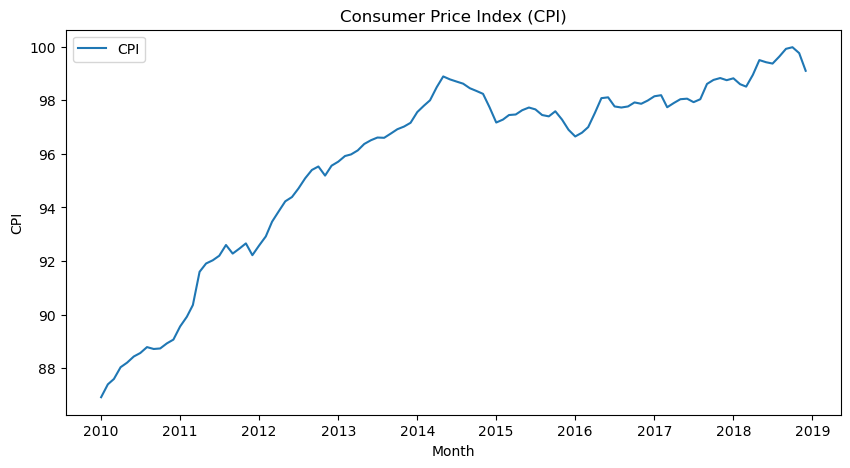

In [252]:
plt.figure(figsize=(10,5))
plt.plot(data_train['cpi'], label = "CPI")
plt.title('Consumer Price Index (CPI)')
plt.xlabel("Month")
plt.ylabel("CPI")
plt.legend()
plt.show()

จากกราฟพบว่าดัชนีราคาผู้บริโภคมีแนวโน้ม ซึ่งอาจมีค่าเฉลี่ยไม่คงที่ โดยอาจต้องทำการหาผลต่างอันดับของดัชนีราคาผู้บริโภค

# 2. ทดสอบคุณสมบัตินิ่งของข้อมูลดัชนีราคาผู้บริโภคของประเทศไทย

ทดสอบคุณสมบัตินิ่งของข้อมูลดัชนีราคาผู้บริโภคของประเทศไทย ประกอบด้วย

2.1 ข้อมูลดัชนีราคาผู้บริโภคของประเทศไทย มีความแปรปรวนคงที่หรือไม่

* ทดสอบด้วยวิธี Box-Cox Tranformation

In [206]:
lambda_data = boxcox_normmax(data_train['cpi'])
print(f'lambda: {lambda_data:.2f}')

lambda: 28.78


จากผลลัพธ์พบว่าค่า lambda มีค่าเท่ากับ 28.96 ซึ่งโดยทั่วไป Box-Cox Transformation มีประโยชน์มากเมื่อค่า lambda อยู่ใกล้ 0 หรือ 1 โดยถ้าาหาก lambda มีค่ามากการแปลงข้อมูลอาจไม่มีผลสำคัญมาก และอาจไม่จำเป็นต้องใช้

In [ ]:
#data_train_transformed = boxcox(data_train, lmbda=28.9635)

2.2 ข้อมูลดัชนีราคาผู้บริโภคของประเทศไทย มีค่าเฉลี่ยคงที่หรือไม่

* ทดสอบด้วยวิธี Augmented Dicky-Fuller Test(ADF Test)

In [217]:
result = adfuller(data_train.cpi)
print(f'ADF Statistic: {result[0]:.4f}')
print(f'p-value: {result[1]:.4f}')

ADF Statistic: -3.1035
p-value: 0.0263


จากผลลัพธ์พบว่า p-value มีค่าเท่ากับ 0.0263 ซึ่งมีค่าน้อยกว่าที่ระดับนัยสำคัญ 0.05 หมายความว่าข้อมูลดัชนีราคาผู้บริโภคของประเทศไทยมีคุณสมบัตินิ่ง จึงไม่จำเป็นต้องหาอันดับผลต่างของข้อมูลดัชนีราคาผู้บริโภคของประเทศไทย

แต่เมื่อผู้วิจัยได้วิเคราะห์ตัวแบบ SARIMA ที่เป็นไปได้ พบว่าไม่มีตัวแบบ SARIMA ใดที่มีความเหมาะสมในการใช้พยากรณ์ดัชนีราคาผู้บริโภคของประเทศไทย ดังนั้นผู้วิจัยจึงทดลองหาอันดับผลต่างของข้อมูลดัชนีราคาผู้บริโภคของประเทศไทย เพื่อวิเคราะห์ตัวแบบ SARIMA ที่เป็นไปได้

* ทำการหาผลต่างอันดับที่ 1 และอันดับที่ 12 เนื่องจากข้อมูลมีฤดูกาลของข้อมูลดัชนีราคาผู้บริโภคของประเทศไทย

In [310]:
data_train["cpi_diff1_diff12"] = data_train["cpi"].diff(1).diff(12)
data_train.dropna(inplace = True)

/var/folders/j4/9cv4ksxd5p11m01b59qb0wyw0000gn/T/ipykernel_4953/847273102.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train["cpi_diff1_diff12"] = data_train["cpi"].diff(1).diff(12)
/var/folders/j4/9cv4ksxd5p11m01b59qb0wyw0000gn/T/ipykernel_4953/847273102.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train.dropna(inplace = True)


ทดสอบคุณสมบัตินิ่งของข้อมูลดัชนีราคาผู้บริโภคของประเทศไทย ด้วยวิธี Augmented Dicky-Fuller Test(ADF Test)

In [312]:
result = adfuller(data_train['cpi_diff1_diff12'])
print(f'ADF Statistic (After Differencing): {result[0]:.4f}')
print(f'p-value (After Differencing): {result[1]:.4f}')

ADF Statistic (After Differencing): -4.0152
p-value (After Differencing): 0.0013


จากผลลัพธ์พบว่า p-value มีค่าเท่ากับ 0.0013 ซึ่งมีค่าน้อยกว่าที่ระดับนัยสำคัญ 0.05 หมายความว่าข้อมูลดัชนีราคาผู้บริโภคของประเทศไทยมีคุณสมบัตินิ่ง และเพียงพอสำหรับใช้ในการวิเคราะห์ตัวแบบ SARIMA

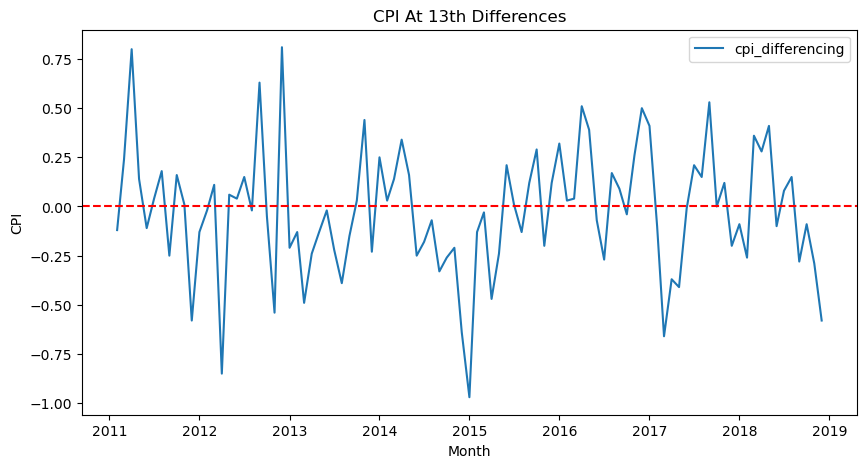

In [259]:
plt.figure(figsize=(10,5))
plt.plot(data_train['cpi_diff1_diff12'], label = "cpi_differencing")
plt.axhline(y=0, color="red", linestyle="--")
plt.xlabel('Month')
plt.ylabel('CPI')
plt.title('CPI At 13th Differences')
plt.legend()
plt.show()

# 3. เขียนกราฟค่าฟังก์ชันสหสัมพันธ์ในตัวเอง (autocorrelation aunction, ACF) และค่าฟังก์ชันสหสัมพันธ์ในตัวเองส่วนย่อย (partial autocorrelation aunction, PACF)

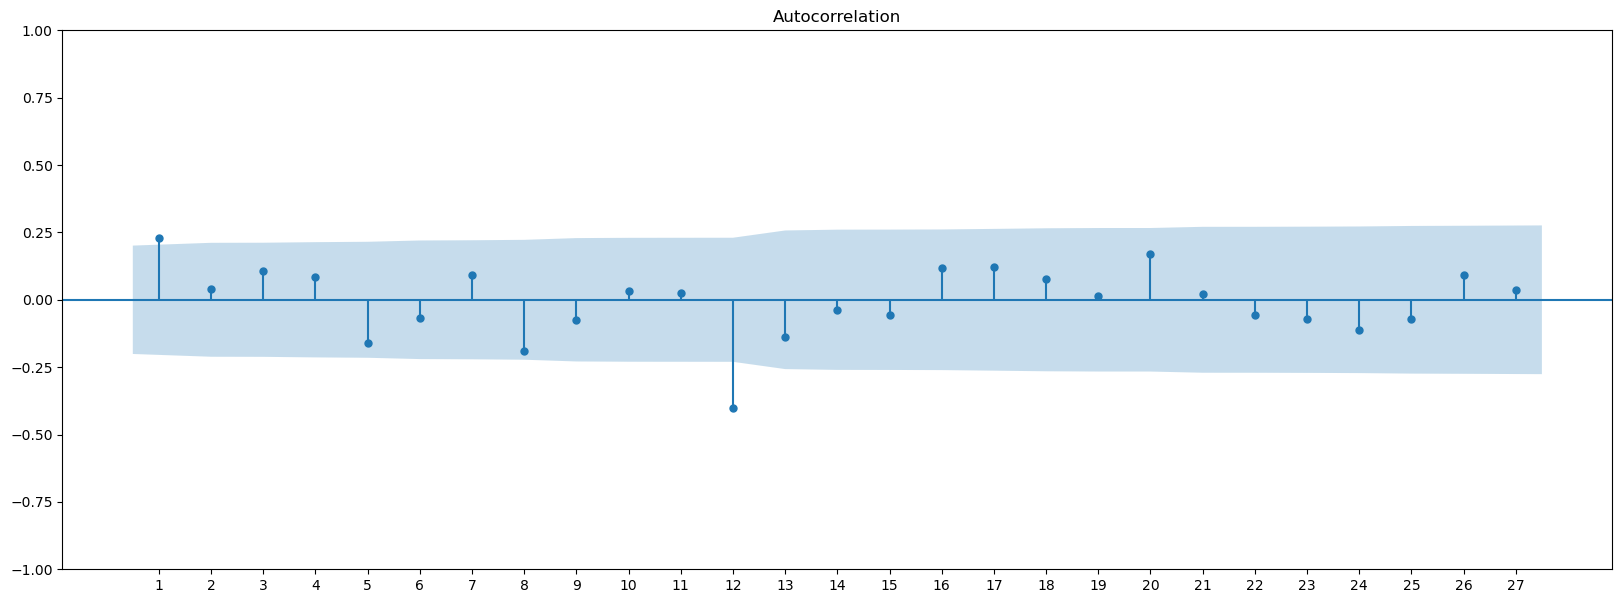

In [34]:
numlags = 27
fig, ax = plt.subplots(figsize=(20,7))
acf_diff1 = plot_acf(data_train["cpi_diff1_diff12"], lags = numlags, zero = False, ax = ax)
ax.set_xticks(np.arange(1, numlags +1, 1))
plt.show()

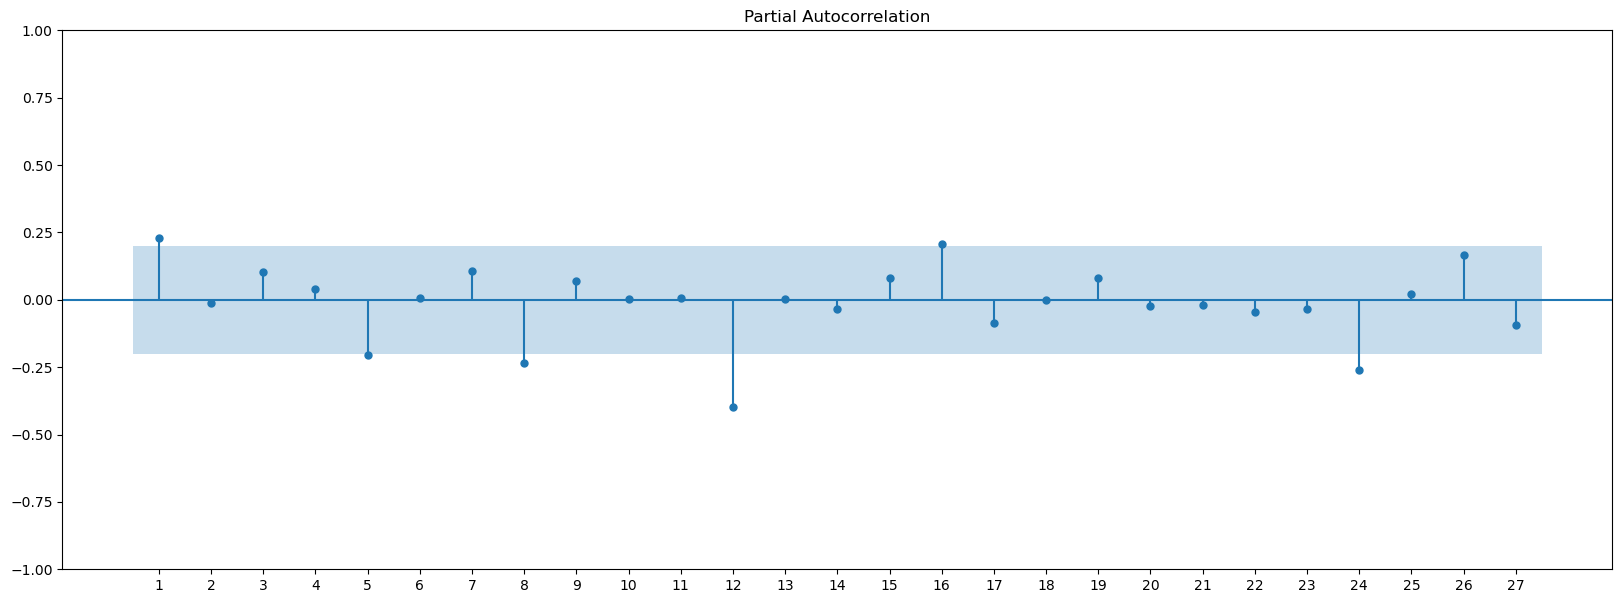

In [36]:
numlags = 27
fig, ax = plt.subplots(figsize=(20,7))
pacf_diff1 = plot_pacf(data_train["cpi_diff1_diff12"], lags = numlags, zero = False, ax = ax)
ax.set_xticks(np.arange(1, numlags +1, 1))
plt.show()

จากกราฟ ACF และ PACF พบว่าข้อมูลดัชนีราคาผู้บริโภคของประเทศไทยมีสหสัมพันธ์ในตัวเอง ณ Lag ที่ 1, 12 และมีสหสัมพันธ์ในตัวเองส่วนย่อย ณ Lag ที่ 1, 12, 24

# 4. ประมาณค่าพารามิเตอร์ของตัวแบบ SARIMA(1,1,0)(2,1,0)s=12 โดยใช้วิธีกำลังสองน้อยที่สุด

In [385]:
model = SARIMAX(data_train['cpi'], order=(1,1,0), seasonal_order=(2,1,0,12), enforce_stationarity=True, enforce_invertibility=True)
model_fit = model.fit()
print(model_fit.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.12149D-01    |proj g|=  9.04244D-01

At iterate    5    f=  7.95783D-02    |proj g|=  1.37371D-01

At iterate   10    f=  7.57830D-02    |proj g|=  4.25157D-02

At iterate   15    f=  7.56200D-02    |proj g|=  1.11468D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     24      1     0     0   2.432D-05   7.562D-02
  F =   7.5619843442279941E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
        

จากผลลัพธ์ข้างต้นพบว่า ค่าพารามิเตอร์ทุกตัวในตัวแบบ SARIMA(1,1,0)(2,1,0)s=12 มี p-value น้อยกว่าที่ระดับนัยสำคัญ 0.05 สรุปได้ว่า พารามิเตอร์ทุกตัวในตัวแบบ SARIMA(1,1,0)(2,1,0)s=12 มีค่าแตกต่างจากศูนย์ กล่าวคือ มีพารามิเตอร์แต่ละตัวอยู่ในตัวแบบ

# 5. ตรวจสอบความเหมาะสมของตัวแบบ SARIMA(1,1,0)(2,1,0)s=12 โดยการวิเคราะห์ส่วนเหลือ(Residual Analysis)

* คำนวณค่าความคลาดเคลื่อนจากการพยากรณ์ด้วยตัวแบบ SARIMA(1,1,0)(2,1,0)s=12 โดยลบข้อมูล 13 อันดับแรกจากการหาอันดับผลต่างของข้อมูลดัชนีรคาผู้บริโภค

In [387]:
residual = model_fit.resid[13:]

5.1 ตรวจสอบสหสัมพันธ์ในตัวเอง (ACF) ของความคลาดเคลื่อนสุ่มที่ได้จากตัวแบบ SARIMA(1,1,0)(2,1,0)s=12

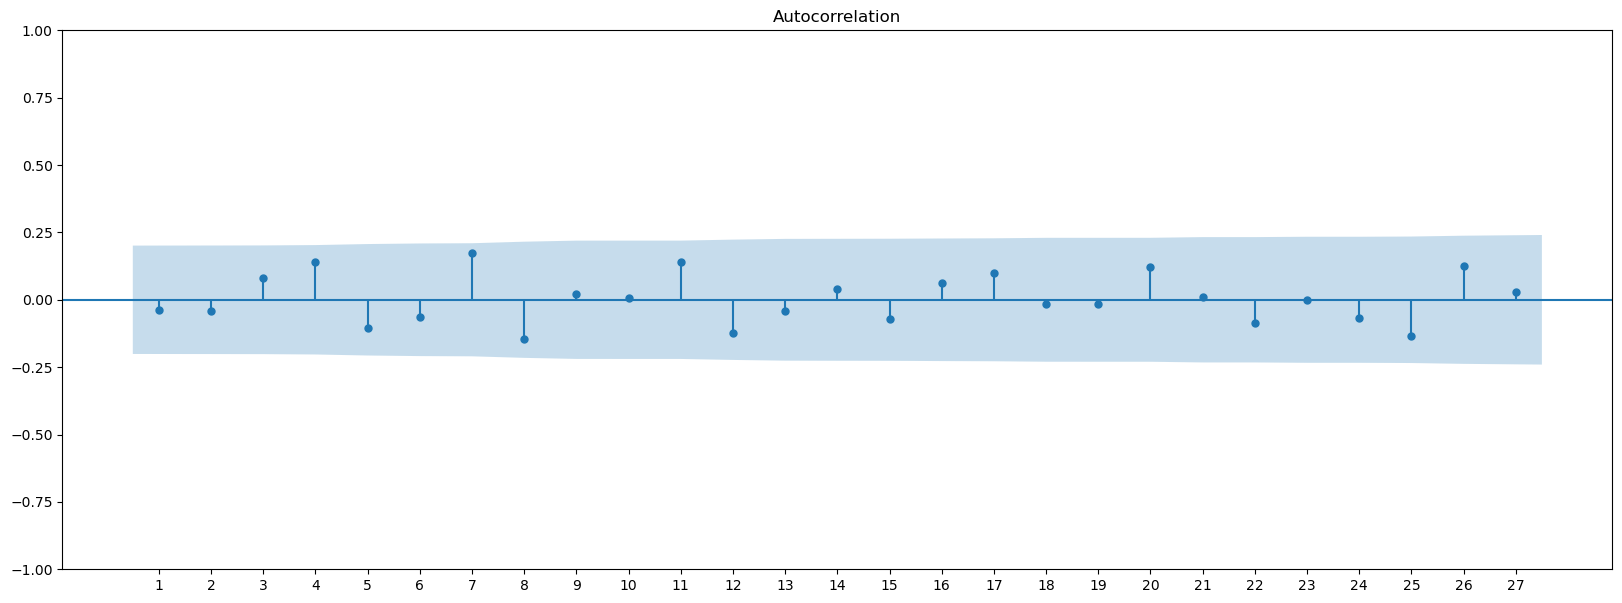

In [389]:
numlags = 27
fig, ax = plt.subplots(figsize=(20,7))
acf_residual = plot_acf(residual, lags = numlags, zero = False, ax=ax)
ax.set_xticks(np.arange(1, numlags +1, 1))
plt.show()

จากการทดสอบพบว่า ค่าฟังก์ชันสหสัมพันธ์ในตัวเอง (ACF) ของความคลาดเคลื่อนสุ่มที่ได้จากตัวแบบ SARIMA(1,1,(20))(2,1,0)s=12 ไม่มีสหสัมพันธ์ในตัวเอง

5.2 ตรวจสอบการแจกแจงปกติของความคลาดเคลื่อนสุ่มที่ได้จากตัวแบบ SARIMA(1,1,0)(2,1,0)s=12 โดยใช้วิธีการทดสอบของ Kolmogorov-Smirnov

In [391]:
ks_statistic, p_value = stats.kstest(residual, 'norm', args=(np.mean(residual), np.std(residual)))
print(f"KS Test Statistic: {ks_statistic:.4f}, P-value: {p_value:.4f}")

KS Test Statistic: 0.0607, P-value: 0.8544


จากการทดสอบของ Kolmogorov-Smirnov พบว่า p-value = 0.8544 ซึ่งมีค่ามากกว่าที่ระดับนับสำคัญ 0.05 สรุปได้ว่า ความคลาดเคลื่อนสุ่มที่ได้จากตัวแบบ SARIMA(1,1,0)(2,1,0)s=12 มีการแจกแจงปกติ

5.3 ตรวจสอบค่าเฉลี่ยไม่แตกต่างจากศูนย์ของความคลาดเคลื่อนสุ่มที่ได้จากตัวแบบ SARIMA(1,1,0)(2,1,0)s=12 โดยใช้ t-Test

In [366]:
t_stat, p_value = stats.ttest_1samp(residual, 0)
print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")

T-statistic: -1.1904, P-value: 0.2369


จากการทดสอบโดยใช้ t-Test พบว่า p-value = 0.2369 ซึ่งมีค่ามากกว่าที่ระดับนับสำคัญ 0.05 สรุปได้ว่า ความคลาดเคลื่อนสุ่มที่ได้จากตัวแบบ SARIMA(1,1,0)(2,1,0)s=12 มีค่าเฉลี่ยไม่แตกต่างจากศูนย์

5.4 ตรวจสอบความแปรปรวนคงที่ของความคลาดเคลื่อนสุ่มที่ได้จากตัวแบบ SARIMA(1,1,0)(2,1,0)s=12 โดยใช้วิธีการทดสอบของ Levene

In [372]:
mid_point = len(residual) // 3
residual1 = residual.iloc[:mid_point] 
residual2 = residual.iloc[mid_point: 2*mid_point]
residual3 = residual.iloc[2*mid_point:]
statistic, p_value = stats.levene(residual1, residual2, residual3)
print(f"Levene's Test Statistic: {statistic:.4f}, P-value: {p_value:.4f}")

Levene's Test Statistic: 2.3544, P-value: 0.1006


จากการทดสอบของ Levene พบว่า p-value = 0.1006 ซึ่งมีค่ามากกว่าที่ระดับนับสำคัญ 0.05 สรุปได้ว่า ความคลาดเคลื่อนสุ่มที่ได้จากตัวแบบ SARIMA(1,1,0)(2,1,0)s=12 มีความแปรปรวนคงที่

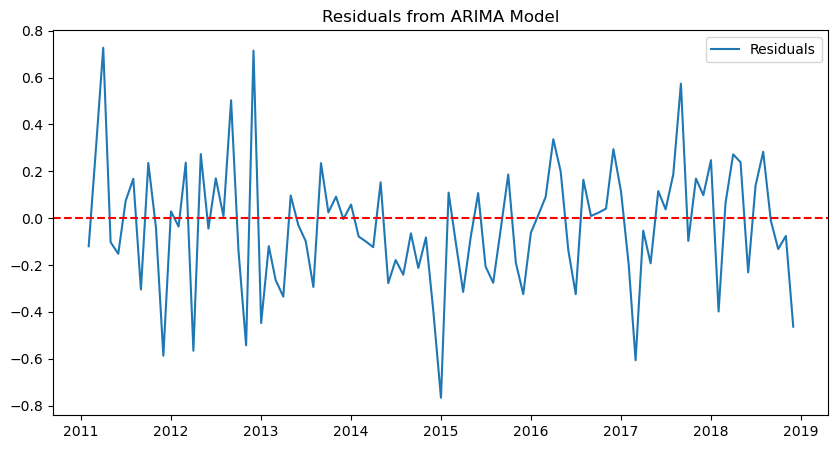

In [370]:
plt.figure(figsize=(10,5))
plt.plot(residual, label="Residuals")
plt.axhline(y=0, color="red", linestyle="--")
plt.title("Residuals from ARIMA Model")
plt.legend()
plt.show()

# 6. วิเคราะห์ประสิทธิภาพในการพยากรณ์จากตัวแบบ SARIMA(1,1,0)(2,1,0)s=12 

วิเคราะห์ประสิทธิภาพในการพยากรณ์จากค่าความคลาดเคลื่อนที่ได้จากการพยากรณ์ด้วยตัวแบบ SARIMA(1,1,0)(2,1,0)s=12 ผ่านชุดข้อมูล Testing Data

In [399]:
forecast = model_fit.forecast(steps=len(data_test))

In [401]:
data_test['forecast_cpi'] = forecast

In [403]:
resid_test = data_test['cpi'] - data_test['forecast_cpi']

In [405]:
data_test['resid_test'] = resid_test

In [407]:
data_test = data_test[13:]

In [423]:
MAD = np.mean(np.abs(data_test['resid_test']))
MSE = np.mean(data_test['resid_test'] ** 2)
MAPE = np.mean(np.abs(data_test['resid_test'] / data_test['cpi'])) * 100
MPE = np.mean(data_test['resid_test'] / data_test['cpi']) * 100
r2 = r2_score(data_test['cpi'], data_test['forecast_cpi'])*100

print(f"MAD: {MAD:.4f}")
print(f"MSE: {MSE:.4f}")
print(f"MAPE: {MAPE:.4f}%")
print(f"R-Squared: {r2:.2f}%")

MAD: 2.4575
MSE: 11.4743
MAPE: 2.3431%
R-Squared: 5.44%


จากการวิเคราะห์เบื้องต้นพบว่า ตัวแบบ SARIMA(1,1,0)(2,1,0)s=12 มีประสิทธิภาพในการพยากรณ์แนวโน้มได้ไม่ดีมากนัก ซึ่งไม่เหมาะกับการพยากรณ์ดัชนีราคาผู้บริโภคของประเทศไทยในระยะยาว

# 7. เขียนกราฟเปรียบเทียบค่าที่แท้จริง กับค่าพยากรณ์ด้วยตัวแบบ SARIMA(1,1,0)(2,1,0)s=12

In [419]:
forecast_data = model_fit.forecast(steps=len(data))

In [436]:
forecast_data = model_fit.predict(start = 0, end = len(data) - 1)

In [445]:
forecast_data

2011-02-01     90.039997
2011-03-01     90.083569
2011-04-01     90.872862
2011-05-01     92.012874
2011-06-01     92.182506
                 ...    
2022-08-01    101.190154
2022-09-01    101.491577
2022-10-01    101.599322
2022-11-01    101.502126
2022-12-01    101.201565
Freq: MS, Name: predicted_mean, Length: 143, dtype: float64

In [440]:
forecast_data = forecast_data[13:]

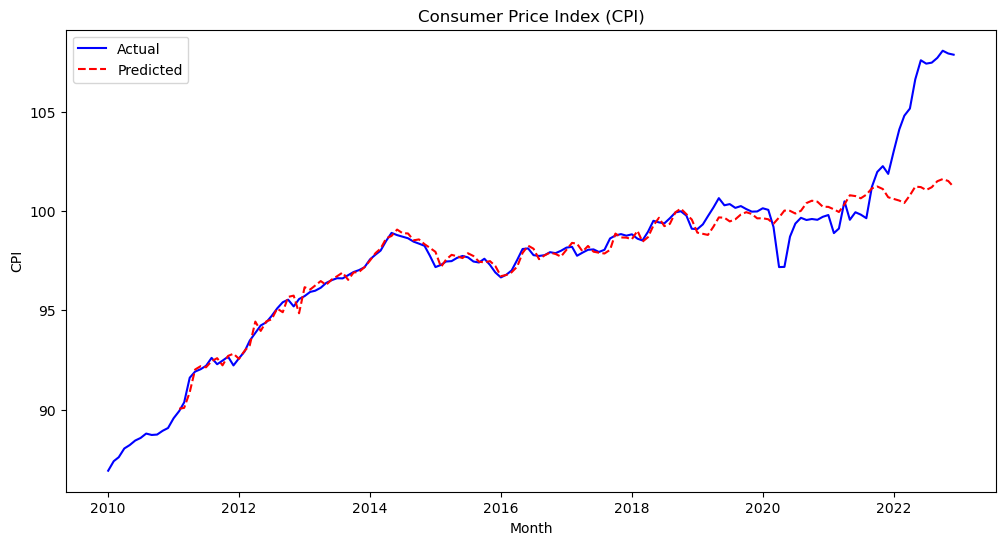

In [451]:
plt.figure(figsize=(12,6))
plt.plot(data['cpi'], label="Actual", color="blue") 
plt.plot(forecast_data, label="Predicted", color="red", linestyle="--")
plt.title('Consumer Price Index (CPI)')
plt.xlabel("Month")
plt.ylabel("CPI")
plt.legend()
plt.show()

จากกราฟพบว่าตัวแบบ SARIMA(1,1,0)(2,1,0)s=12 มีประสิทธิภาพในการพยากรณ์ในช่วงระยะสั้นค่อนข้างแม่นยำ แต่มีประสิทธิภาพในการพยากรณ์ใช่ช่วงระยะยาวค่อนข้างต่ำ เนื่องจากตัวแบบ SARIMA(1,1,0)(2,1,0)s=12 มีประสิทธิภาพในการพยากรณ์แนวโน้มได้ไม่ดีมากนัก ซึ่งอาจต้องคำนึงถึงปัจจัยที่อาจมีผลต่อดัชนีราคาผู้บริโภคเข้ามาพิจารณาร่วมกับตัวแบบ SARIMA